In [1]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

Using TensorFlow backend.


In [2]:
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()
SHORT_SIZE = 10000
x_train_mnist = x_train_mnist[:SHORT_SIZE]
y_train_mnist = y_train_mnist[:SHORT_SIZE]
x_train_mnist = x_train_mnist.reshape(x_train_mnist.shape[0], 28, 28, 1)
x_test_mnist = x_test_mnist.reshape(x_test_mnist.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
x_train_mnist = x_train_mnist.astype('float32')
x_test_mnist = x_test_mnist.astype('float32')
x_train_mnist /= 255
x_test_mnist /= 255

bankdata = pd.read_csv("bill_authentication.csv")
x_bill = bankdata.drop('Class', axis=1)
y_bill = bankdata['Class']
x_train_bill, x_test_bill, y_train_bill, y_test_bill = train_test_split(x_bill, y_bill, test_size = 0.20)

iris_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris_colnames = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'Class']
irisdata = pd.read_csv(iris_url, names=iris_colnames)
x_iris = irisdata.drop('Class', axis=1)
y_iris = irisdata['Class']
x_train_iris, x_test_iris, y_train_iris, y_test_iris = train_test_split(x_iris, y_iris, test_size = 0.20)

In [3]:
mnist_input_shape = (28, 28, 1)
def create_sequential_model():
    model = Sequential()
    model.add(Conv2D(28, kernel_size=(3,3), input_shape=mnist_input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.nn.relu))
    model.add(Dropout(0.2))
    model.add(Dense(10,activation=tf.nn.softmax))
    model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
    return model

def create_linear_svc_model():
    return SVC(kernel='linear',probability=True)

def create_rbf_svc_model():
    return SVC(kernel='rbf',probability=True,gamma='auto')

In [4]:
def query_default(model, x_train, labeled, batch_size, reshape_f):
    res = []
    for i in range(len(x_train)):
        if not labeled[i]:
            res += [i]
        if len(res) == batch_size:
            return res
    return res

# def f1(p):
#     return max(p)

# def f2(p):
#     return sorted(p)[-1] - sorted(p)[-2]

# def f_entropy(p):
#     return sum([e * math.log((e + math.pow(10, -10))) for e in p])

def f1(p):
    return 1 - max(p)

def f2(p):
    return 1 - (sorted(p)[-1] - sorted(p)[-2])

def f_entropy(p):
    return -1 * sum([e * math.log((e + math.pow(10, -10))) for e in p])

img_rows = img_cols = 28

def reshape_mnist(x):
    return x.reshape(1, img_rows, img_cols, 1)

def reshape_svc(x):
    return x.reshape(1, -1)

def query_uncert(model, x_train, labeled, batch_size, uncert_f, reshape_f):
    pre_batch = []
    for i in range(len(x_train)):
        if not labeled[i]:
            p = model.predict_proba(reshape_f(x_train[i]))
            pre_batch.append((uncert_f(p.flatten()), i))
    #return [i for (p, i) in sorted(pre_batch)[:batch_size]]
    return [i for (p, i) in sorted(pre_batch)[::-1][:batch_size]]

def query_uncert_1(model, x_train, labeled, batch_size, reshape_f):
    return query_uncert(model, x_train, labeled, batch_size, f1, reshape_f)

def query_uncert_2(model, x_train, labeled, batch_size, reshape_f):
    return query_uncert(model, x_train, labeled, batch_size, f2, reshape_f)

def query_entropy(model, x_train, labeled, batch_size, reshape_f):
    return query_uncert(model, x_train, labeled, batch_size, f_entropy, reshape_f)

def score_sequential(model, x_test, y_test):
    return model.evaluate(x_test, y_test, verbose=0)[1]

def score_svc(model, x_test, y_test):
    return model.score(x_test, y_test)

In [5]:
def run_AL(
    query_f, 
    create_model, 
    reshape_f,
    score_f,
    x_train, y_train, x_test, y_test, 
    init_size, batch_size, query_number
):
    model = create_model()
    x_train_labeled = x_train[:init_size]
    y_train_labeled = y_train[:init_size]
    labeled = [True if i < init_size else False for i in range(x_train.shape[0])]
    model.fit(x_train_labeled, y_train_labeled)
    acc_growth = [(x_train_labeled.shape[0], score_f(model, x_test, y_test))]
    for i in range(query_number):
        query = query_f(model, x_train, labeled, batch_size, reshape_f)
        for i in query:
            x_train_labeled = np.append(x_train_labeled, [x_train[i]], axis = 0)
            y_train_labeled = np.append(y_train_labeled, [y_train[i]], axis = 0)
            labeled[i] = True
        model.fit(x_train_labeled, y_train_labeled)
        acc_growth += [(x_train_labeled.shape[0], score_f(model, x_test, y_test))]
    return acc_growth

In [12]:
random_iris = run_AL(query_default, create_rbf_svc_model, reshape_svc, score_svc, 
                    x_train_iris.to_numpy(), 
                    y_train_iris.to_numpy(), 
                    x_test_iris.to_numpy(), 
                    y_test_iris.to_numpy(),
                    3, 1, 50)
entropy_iris = run_AL(query_entropy, create_rbf_svc_model, reshape_svc, score_svc, 
                    x_train_iris.to_numpy(), 
                    y_train_iris.to_numpy(), 
                    x_test_iris.to_numpy(), 
                    y_test_iris.to_numpy(),
                    3, 1, 50)

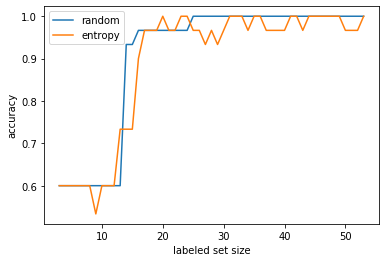

In [22]:
xs_random = [e[0] for e in random_iris]
ys_random = [e[1] for e in random_iris]
xs_entropy = [e[0] for e in entropy_iris]
ys_entropy = [e[1] for e in entropy_iris]
plt.plot(xs_random, ys_random, label='random')
plt.plot(xs_entropy, ys_entropy, label='entropy')
plt.xlabel('labeled set size')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [13]:
random_bill = run_AL(query_default, create_linear_svc_model, reshape_svc, score_svc, 
                    x_train_bill.to_numpy(), 
                    y_train_bill.to_numpy(), 
                    x_test_bill.to_numpy(), 
                    y_test_bill.to_numpy(),
                    5, 1, 35)
entropy_bill = run_AL(query_entropy, create_linear_svc_model, reshape_svc, score_svc, 
                    x_train_bill.to_numpy(), 
                    y_train_bill.to_numpy(), 
                    x_test_bill.to_numpy(), 
                    y_test_bill.to_numpy(),
                    5, 1, 35)

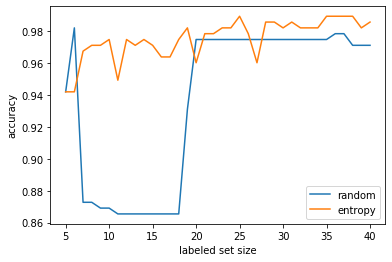

In [26]:
xs_random = [e[0] for e in random_bill]
ys_random = [e[1] for e in random_bill]
xs_entropy = [e[0] for e in entropy_bill]
ys_entropy = [e[1] for e in entropy_bill]
plt.plot(xs_random, ys_random, label='random')
plt.plot(xs_entropy, ys_entropy, label='entropy')
plt.xlabel('labeled set size')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [18]:
random_mnist = run_AL(query_default, create_sequential_model, reshape_mnist, score_sequential, 
                    x_train_mnist, 
                    y_train_mnist, 
                    x_test_mnist, 
                    y_test_mnist,
                    2000, 1, 100)
entropy_mnist = run_AL(query_entropy, create_sequential_model, reshape_mnist, score_sequential, 
                    x_train_mnist, 
                    y_train_mnist, 
                    x_test_mnist, 
                    y_test_mnist,
                    2000, 1, 100)

NameError: name 'x' is not defined

In [19]:
xs_random = [e[0] for e in random_mnist]
ys_random = [e[1] for e in random_mnist]
xs_entropy = [e[0] for e in entropy_mnist]
ys_entropy = [e[1] for e in entropy_mnist]
plt.plot(xs_random, ys_random, label='random')
plt.plot(xs_entropy, ys_entropy, label='entropy')
plt.xlabel('labeled set size')
plt.ylabel('accuracy')
plt.legend()
plt.show()

NameError: name 'random_mnist' is not defined

In [ ]:
seq_statistic = []
seq_statistic.append(('random', 2000, random_mnist))
seq_statistic.append(('entropy', 2000, entropy_mnist))
for init_size in [500, 1000, 3000, 5000]:
    seq_statistic.append(('random', init_size, run_AL(query_default, create_sequential_model, reshape_mnist, score_sequential, 
                                                x_train_mnist, 
                                                y_train_mnist, 
                                                x_test_mnist, 
                                                y_test_mnist,
                                                init_size, 1, 100)))
    seq_statistic.append(('entropy', init_size, run_AL(query_default, create_sequential_model, reshape_mnist, score_sequential, 
                                                x_train_mnist, 
                                                y_train_mnist, 
                                                x_test_mnist, 
                                                y_test_mnist,
                                                init_size, 1, 100)))

In [175]:
import pickle

with open('seq_statistic.pkl', 'wb') as f:
    pickle.dump(seq_statistic, f)

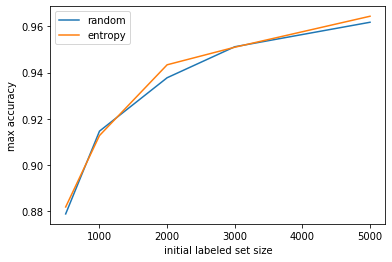

In [177]:
xs_random = [s[1] for s in sorted([s for s in seq_statistic if s[0] == 'random'], key=lambda s:s[1])]
ys_random = [max([pair[1] for pair in s[2]]) for s in sorted([s for s in seq_statistic if s[0] == 'random'], key=lambda x:x[1])]
xs_entropy = [s[1] for s in sorted([s for s in seq_statistic if s[0] == 'entropy'], key=lambda s:s[1])]
ys_entropy = [max([pair[1] for pair in s[2]]) for s in sorted([s for s in seq_statistic if s[0] == 'entropy'], key=lambda x:x[1])]
plt.plot(xs_random, ys_random, label='random')
plt.plot(xs_entropy, ys_entropy, label='entropy')
plt.xlabel('initial labeled set size')
plt.ylabel('max accuracy')
plt.legend()
plt.show()

## Density-Weighted Method
Let's compute center of mass of unlabeled set. Thus we can calculate unsimilarity of one point from others by O(1). Also we can recalculate center of mass after extracting instance simply subtracting vector of choosen instance from vector sum of all unlabeled data instances.

x* (query) will be calculated like **x* = argmax_x (VOI(x) * Unsim(x))** where VOI(x) - informativness, in case below it would be uncertainty, Unsim(x) - distance between **x** and center of mass.

In [7]:
unsim_coef = 0.01

def query_uncert_dwm(model, x_train, labeled, batch_size, uncert_f, reshape_f, mass_center):
    pre_batch = []
    for i in range(len(x_train)):
        if not labeled[i]:
            p = model.predict_proba(reshape_f(x_train[i]))
            unsim = abs(sum(x_train[i].flatten() - mass_center)) ** unsim_coef
            pre_batch.append((uncert_f(p.flatten()) * unsim, i))
    return [i for (p, i) in sorted(pre_batch)[::-1][:batch_size]]

def query_uncert_1_dwm(model, x_train, labeled, batch_size, reshape_f, mass_center):
    return query_uncert_dwm(model, x_train, labeled, batch_size, f1, reshape_f, mass_center)

def query_uncert_2_dwm(model, x_train, labeled, batch_size, reshape_f, mass_center):
    return query_uncert_dwm(model, x_train, labeled, batch_size, f2, reshape_f, mass_center)

def query_entropy_dwm(model, x_train, labeled, batch_size, reshape_f, mass_center):
    return query_uncert_dwm(model, x_train, labeled, batch_size, f_entropy, reshape_f, mass_center)

In [8]:
def run_DWM(
    query_f, 
    create_model, 
    reshape_f,
    score_f,
    x_train, y_train, x_test, y_test, 
    init_size, batch_size, query_number
):
    x_train, y_train = shuffle(x_train, y_train, random_state=0)
    model = create_model()
    x_train_labeled = x_train[:init_size]
    y_train_labeled = y_train[:init_size]
    
    center_vector = np.sum([e.flatten() for e in x_train_labeled], axis=0)
    unlabeled_size = len(x_train) - init_size
    mass_center = center_vector / unlabeled_size
    #print(mass_center)
    labeled = [True if i < init_size else False for i in range(x_train.shape[0])]
    model.fit(x_train_labeled, y_train_labeled)
    acc_growth = [(x_train_labeled.shape[0], score_f(model, x_test, y_test))]
    for i in range(query_number):
        query = query_f(model, x_train, labeled, batch_size, reshape_f, mass_center)
        for i in query:
            x_train_labeled = np.append(x_train_labeled, [x_train[i]], axis = 0)
            y_train_labeled = np.append(y_train_labeled, [y_train[i]], axis = 0)
            labeled[i] = True
            center_vector -= x_train[i].flatten()
        
        unlabeled_size -= batch_size
        mass_center = center_vector / unlabeled_size
        #print(mass_center)
        model.fit(x_train_labeled, y_train_labeled)
        acc_growth += [(x_train_labeled.shape[0], score_f(model, x_test, y_test))]
    return acc_growth

In [14]:
unsim_coef = 0.3
entropy_dwm_bill = run_DWM(query_entropy_dwm, create_linear_svc_model, reshape_svc, score_svc, 
                    x_train_bill.to_numpy(), 
                    y_train_bill.to_numpy(), 
                    x_test_bill.to_numpy(), 
                    y_test_bill.to_numpy(),
                    5, 1, 35)

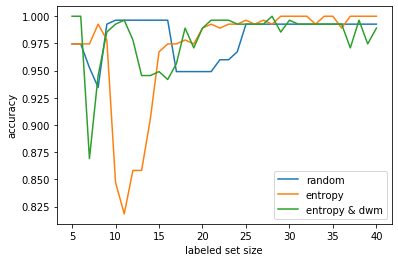

In [15]:
xs_random = [e[0] for e in random_bill]
ys_random = [e[1] for e in random_bill]
plt.plot(xs_random, ys_random, label='random')

xs_entropy = [e[0] for e in entropy_bill]
ys_entropy = [e[1] for e in entropy_bill]
plt.plot(xs_entropy, ys_entropy, label='entropy')

xs_entropy_dwm = [e[0] for e in entropy_dwm_bill]
ys_entropy_dwm = [e[1] for e in entropy_dwm_bill]
plt.plot(xs_entropy_dwm, ys_entropy_dwm, label='entropy & dwm')

plt.xlabel('labeled set size')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [23]:
entropy_dwm_bill_stat = []
for i in range(1, 100, 5):
    unsim_coef = 0.01 * i
    entropy_dwm_bill_stat.append((unsim_coef, run_DWM(query_entropy_dwm, 
                                                      create_linear_svc_model, 
                                                      reshape_svc, 
                                                      score_svc, 
                                                      x_train_bill.to_numpy(), 
                                                      y_train_bill.to_numpy(), 
                                                      x_test_bill.to_numpy(), 
                                                      y_test_bill.to_numpy(),
                                                      5, 1, 35)))
    print(unsim_coef)
#     xs_random = [e[0] for e in random_iris]
#     ys_random = [e[1] for e in random_iris]
#     plt.plot(xs_random, ys_random, label='random')

#     xs_entropy = [e[0] for e in entropy_iris]
#     ys_entropy = [e[1] for e in entropy_iris]
#     plt.plot(xs_entropy, ys_entropy, label='entropy')

#     xs_entropy_dwm = [e[0] for e in entropy_dwm_iris_stat[-1][1]]
#     ys_entropy_dwm = [e[1] for e in entropy_dwm_iris_stat[-1][1]]
#     plt.plot(xs_entropy_dwm, ys_entropy_dwm, label='entropy & dwm')

#     plt.xlabel('labeled set size')
#     plt.ylabel('accuracy')
#     plt.legend()
#     plt.show()

0.01
0.06
0.11
0.16
0.21
0.26
0.31
0.36
0.41000000000000003
0.46
0.51
0.56
0.61
0.66
0.71
0.76
0.81
0.86
0.91
0.96


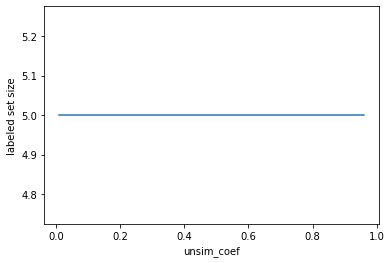

In [24]:
xs_entropy_dwm_stat = [s[0] for s in entropy_dwm_bill_stat]
ys_entropy_dwm_stat = []
for s in entropy_dwm_bill_stat:
    max_acc = max([p[1] for p in s[1]])
    i = 0
    while i < len(s[1]) and s[1][i][1] != max_acc:
        i += 1
    ys_entropy_dwm_stat += [s[1][i][0]]

plt.plot(xs_entropy_dwm_stat, ys_entropy_dwm_stat)
plt.xlabel('unsim_coef')
plt.ylabel('labeled set size')
plt.show()

In [18]:
entropy_dwm_iris_stat = []
for i in range(1, 100, 5):
    unsim_coef = 0.01 * i
    entropy_dwm_iris_stat.append((unsim_coef, run_DWM(query_entropy_dwm, 
                                                      create_rbf_svc_model, 
                                                      reshape_svc, 
                                                      score_svc, 
                                                      x_train_iris.to_numpy(), 
                                                      y_train_iris.to_numpy(), 
                                                      x_test_iris.to_numpy(), 
                                                      y_test_iris.to_numpy(),
                                                      5, 1, 35)))
#     print(unsim_coef)
#     xs_random = [e[0] for e in random_iris]
#     ys_random = [e[1] for e in random_iris]
#     plt.plot(xs_random, ys_random, label='random')

#     xs_entropy = [e[0] for e in entropy_iris]
#     ys_entropy = [e[1] for e in entropy_iris]
#     plt.plot(xs_entropy, ys_entropy, label='entropy')

#     xs_entropy_dwm = [e[0] for e in entropy_dwm_iris_stat[-1][1]]
#     ys_entropy_dwm = [e[1] for e in entropy_dwm_iris_stat[-1][1]]
#     plt.plot(xs_entropy_dwm, ys_entropy_dwm, label='entropy & dwm')

#     plt.xlabel('labeled set size')
#     plt.ylabel('accuracy')
#     plt.legend()
#     plt.show()

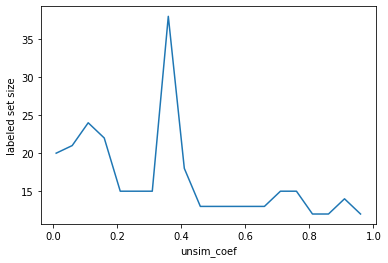

In [19]:
xs_entropy_dwm_stat = [s[0] for s in entropy_dwm_iris_stat]
ys_entropy_dwm_stat = []
for s in entropy_dwm_iris_stat:
    max_acc = max([p[1] for p in s[1]])
    i = 0
    while i < len(s[1]) and s[1][i][1] != max_acc:
        i += 1
    ys_entropy_dwm_stat += [s[1][i][0]]

plt.plot(xs_entropy_dwm_stat, ys_entropy_dwm_stat)
plt.xlabel('unsim_coef')
plt.ylabel('labeled set size')
plt.show()

In [20]:
entropy_dwm_iris = run_DWM(query_entropy_dwm, create_rbf_svc_model, reshape_svc, score_svc, 
                    x_train_iris.to_numpy(), 
                    y_train_iris.to_numpy(), 
                    x_test_iris.to_numpy(), 
                    y_test_iris.to_numpy(),
                    5, 1, 35)

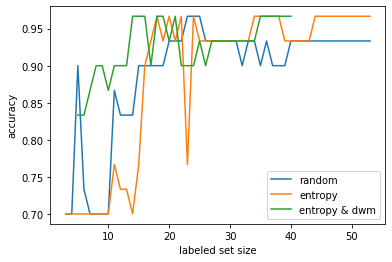

In [21]:
xs_random = [e[0] for e in random_iris]
ys_random = [e[1] for e in random_iris]
plt.plot(xs_random, ys_random, label='random')

xs_entropy = [e[0] for e in entropy_iris]
ys_entropy = [e[1] for e in entropy_iris]
plt.plot(xs_entropy, ys_entropy, label='entropy')

xs_entropy_dwm = [e[0] for e in entropy_dwm_iris]
ys_entropy_dwm = [e[1] for e in entropy_dwm_iris]
plt.plot(xs_entropy_dwm, ys_entropy_dwm, label='entropy & dwm')

plt.xlabel('labeled set size')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [25]:
entropy_mnist_dwm = run_DWM(query_entropy_dwm, create_sequential_model, reshape_mnist, score_sequential, 
                    x_train_mnist, 
                    y_train_mnist, 
                    x_test_mnist, 
                    y_test_mnist,
                    2000, 1, 100)

Epoch 1/1
2000/2000 [==============================] - 1s 692us/step - loss: 0.8801 - accuracy: 0.7450
Epoch 1/1
2001/2001 [==============================] - 2s 785us/step - loss: 0.3418 - accuracy: 0.9020
Epoch 1/1
2002/2002 [==============================] - 1s 665us/step - loss: 0.2243 - accuracy: 0.9266
Epoch 1/1
2003/2003 [==============================] - 1s 577us/step - loss: 0.1758 - accuracy: 0.9421
Epoch 1/1
2004/2004 [==============================] - 1s 594us/step - loss: 0.1155 - accuracy: 0.9671
Epoch 1/1
2005/2005 [==============================] - 1s 616us/step - loss: 0.1000 - accuracy: 0.9726
Epoch 1/1
2006/2006 [==============================] - 1s 639us/step - loss: 0.0670 - accuracy: 0.9835
Epoch 1/1
2007/2007 [==============================] - 1s 614us/step - loss: 0.0604 - accuracy: 0.9811
Epoch 1/1
2008/2008 [==============================] - 1s 653us/step - loss: 0.0463 - accuracy: 0.9880
Epoch 1/1
2009/2009 [==============================] - 1s 633us/step - lo

2079/2079 [==============================] - 1s 536us/step - loss: 0.0043 - accuracy: 0.9986
Epoch 1/1
2080/2080 [==============================] - 1s 517us/step - loss: 0.0057 - accuracy: 0.9976
Epoch 1/1
2081/2081 [==============================] - 1s 554us/step - loss: 0.0086 - accuracy: 0.9971
Epoch 1/1
2082/2082 [==============================] - 1s 496us/step - loss: 0.0034 - accuracy: 0.9986
Epoch 1/1
2083/2083 [==============================] - 1s 659us/step - loss: 0.0128 - accuracy: 0.9971
Epoch 1/1
2084/2084 [==============================] - 1s 641us/step - loss: 0.0040 - accuracy: 0.9976
Epoch 1/1
2085/2085 [==============================] - 1s 633us/step - loss: 0.0090 - accuracy: 0.9976
Epoch 1/1
2086/2086 [==============================] - 1s 649us/step - loss: 0.0031 - accuracy: 0.9995
Epoch 1/1
2087/2087 [==============================] - 1s 631us/step - loss: 0.0054 - accuracy: 0.9981
Epoch 1/1
2088/2088 [==============================] - 1s 623us/step - loss: 0.0027

In [26]:
import pickle

file = open('seq_statistic.pkl', 'rb')
seq_statistic = pickle.load(file)


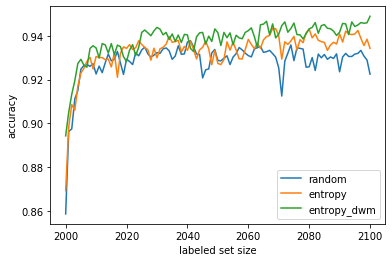

In [27]:
xs_random = [e[0] for e in seq_statistic[0][2]]
ys_random = [e[1] for e in seq_statistic[0][2]]
plt.plot(xs_random, ys_random, label='random')

xs_entropy = [e[0] for e in seq_statistic[1][2]]
ys_entropy = [e[1] for e in seq_statistic[1][2]]
plt.plot(xs_entropy, ys_entropy, label='entropy')

xs_entropy_dwm = [e[0] for e in entropy_mnist_dwm]
ys_entropy_dwm = [e[1] for e in entropy_mnist_dwm]
plt.plot(xs_entropy_dwm, ys_entropy_dwm, label='entropy_dwm')
plt.xlabel('labeled set size')
plt.ylabel('accuracy')
plt.legend()
plt.show()